## Online Fraud Prediction

In [1]:
# import zipfile
# with zipfile.ZipFile("onlinefraud.csv.zip","r") as zip_ref:
#     zip_ref.extractall()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


### Read the dataset

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Freelance/Alberto/AI_fraud/onlinefraud.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Data Dictionary

- oldbalanceOrg: represents a unit of time where 1 oldbalanceOrg equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction

Test the following classifiers:

    "LR": LogisticRegression()
    "KNN": KNeighborsClassifier()
    "DT": DecisionTreeClassifier()
    "RF": RandomForestClassifier()
    "XGB": XGBClassifier()
    "Naive Bayes": GaussianNB()
    "SVC": SVC()

### Data Cleaning

In [5]:
data.step.value_counts()

19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: step, Length: 743, dtype: int64

In [6]:
# cleaning the data
data = data.drop(['step'], axis=1)
data = data.drop(['nameOrig'], axis=1)
data = data.drop(['nameDest'], axis=1)
data = data.drop(['isFlaggedFraud'], axis=1)
data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [7]:
# checking for null values and data types of the columns in the dataset 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 339.8+ MB


In [8]:
data.isnull().sum()

type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

- There are no null values in the required columns of the dataset

In [9]:
# checking for the number of unique values in each column
data.nunique()

type                    5
amount            5316900
oldbalanceOrg     1845844
newbalanceOrig    2682586
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
dtype: int64

In [10]:
# check for duplicates in the dataset
data.duplicated().sum()

97880

In [11]:
data.shape

(6362620, 7)

In [12]:
# # remove duplicates from the dataset
# data.drop_duplicates(inplace=True)
# data.shape

In [13]:
# check for outliers in the dataset
data.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


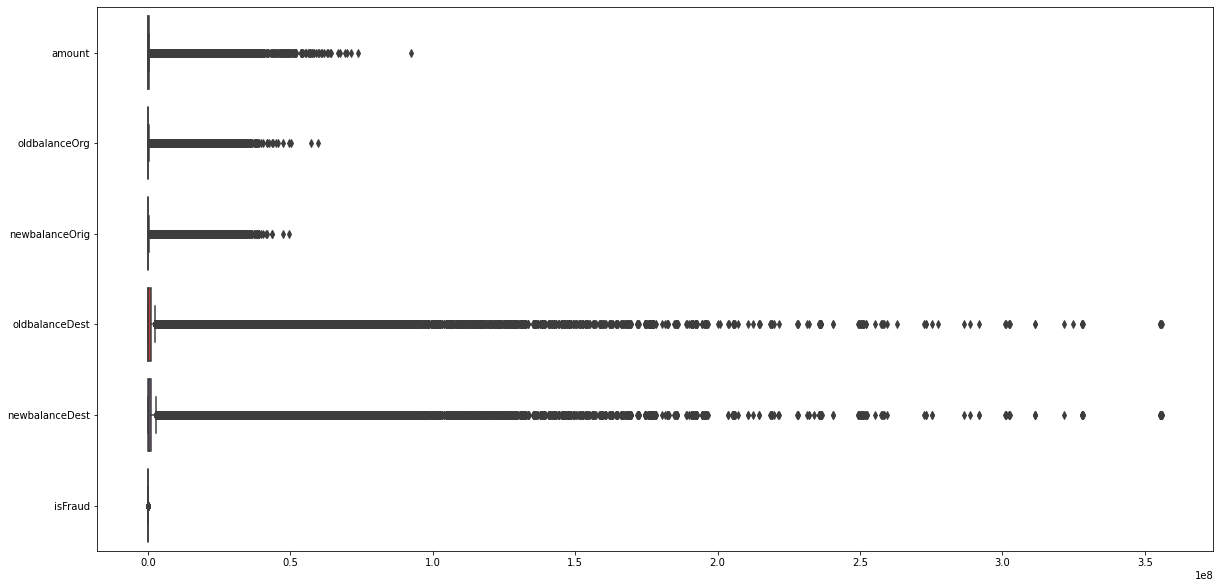

In [14]:
# perform some visualizations to check for outliers with big image size and the labels are rotated
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=data, orient='h', ax=ax)


- We can observe that there are some outliers present in the data so these need to be cleaned. As there are 5 columns that require their outliers to be removed so performing IQR on the whole data

- But as this is a fraud detection problem so outliers even play a major role in detecting frauds as the outlier may have also  occured due to fraud, so we would primarily train a model without removing outliers and then try to remove outliers and try to train the model again

In [15]:
# function to remove outliers of a certain column
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [16]:
# # code to remove outliers from amount column
# Q1 = data['amount'].quantile(0.25)
# Q3 = data['amount'].quantile(0.75)
# IQR = Q3 - Q1
# data = data[(data['amount'] >= Q1 - 1.5*IQR) & (data['amount'] <= Q3 + 1.5*IQR)]
# data.shape

In [17]:
# # code to remove outliers from oldbalanceOrg column
# Q1 = data['oldbalanceOrg'].quantile(0.25)
# Q3 = data['oldbalanceOrg'].quantile(0.75)
# IQR = Q3 - Q1
# data = data[(data['oldbalanceOrg'] >= Q1 - 1.5*IQR) & (data['oldbalanceOrg'] <= Q3 + 1.5*IQR)]
# data.shape

In [18]:
# # code to remove outliers from newbalanceOrig column
# Q1 = data['newbalanceOrig'].quantile(0.25)
# Q3 = data['newbalanceOrig'].quantile(0.75)
# IQR = Q3 - Q1

# data = data[(data['newbalanceOrig'] >= Q1 - 1.5*IQR) & (data['newbalanceOrig'] <= Q3 + 1.5*IQR)]
# data.shape

In [19]:
# # code to remove outliers from oldbalanceDest column
# Q1 = data['oldbalanceDest'].quantile(0.25)
# Q3 = data['oldbalanceDest'].quantile(0.75)
# IQR = Q3 - Q1
# data = data[(data['oldbalanceDest'] >= Q1 - 1.5*IQR) & (data['oldbalanceDest'] <= Q3 + 1.5*IQR)]
# data.shape

In [20]:
# # code to remove outliers from newbalanceDest column
# Q1 = data['newbalanceDest'].quantile(0.25)
# Q3 = data['newbalanceDest'].quantile(0.75)
# IQR = Q3 - Q1
# data = data[(data['newbalanceDest'] >= Q1 - 1.5*IQR) & (data['newbalanceDest'] <= Q3 + 1.5*IQR)]
# data.shape


In [21]:
data.dtypes

type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

### EDA

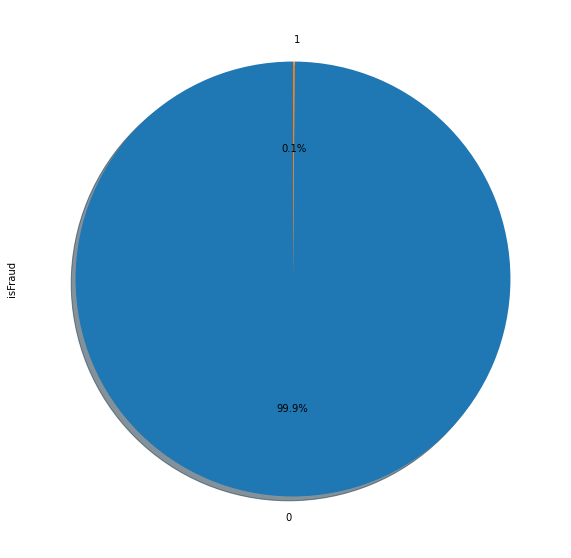

In [22]:
# plot a piechart with labels for the target column isFraud
data['isFraud'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, startangle=90, figsize=(10,10))

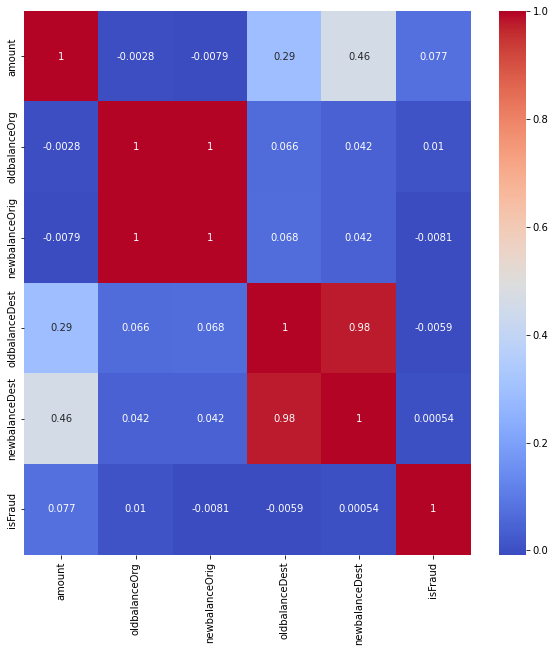

In [23]:
# Plot a correlation heatmap to check for correlation between the features
corr=data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')


- We can observe that there is a high correlation between newbalancedest and oldbalancedest and also there is a high correlation between oldbalanceOrig and newbalanceOrig so we can remove one feature from each of these correlations, so we are removing the old ones here.

In [24]:
# drop the oldbalanceDest column and oldbalanceOrg column as they have high correlation with the newbalanceDest and newbalanceOrg columns
data.drop(['oldbalanceDest'], axis=1, inplace=True)
data.drop(['oldbalanceOrg'], axis=1, inplace=True)
data.head()

,type,amount,newbalanceOrig,newbalanceDest,isFraud
0,PAYMENT,9839.64,160296.36,0.0,0
1,PAYMENT,1864.28,19384.72,0.0,0
2,TRANSFER,181.00,0.00,0.0,1
3,CASH_OUT,181.00,0.00,0.0,1
4,PAYMENT,11668.14,29885.86,0.0,0


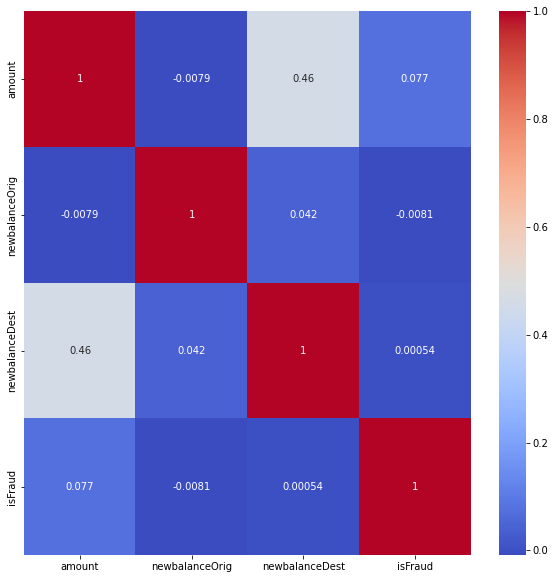

In [25]:
# Plot a correlation heatmap to check for correlation between the features
corr=data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')


In [26]:
# check for the number of unique values in each column
data.nunique()

type                    5
amount            5316900
newbalanceOrig    2682586
newbalanceDest    3555499
isFraud                 2
dtype: int64

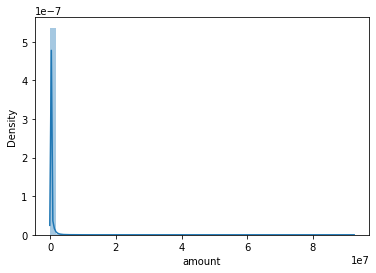

In [27]:
# plot the distribution of the amount column
sns.distplot(data['amount'])


In [28]:
data.amount.max()

92445516.64

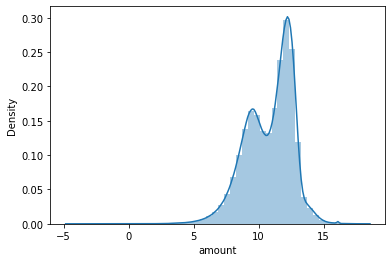

In [29]:
# As we observe that the amount column is highly skewed, we will perform log transformation on the amount column
data['amount'] = np.log(data['amount'], where=data['amount']!=0)
# plot the distribution of the amount column
sns.distplot(data['amount'])

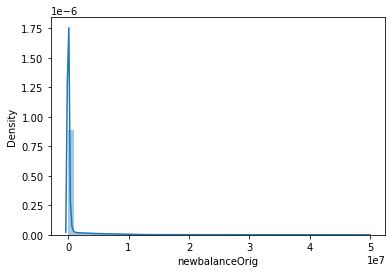

In [30]:
# plot the distribution of the newbalanceOrig column
sns.distplot(data['newbalanceOrig'])

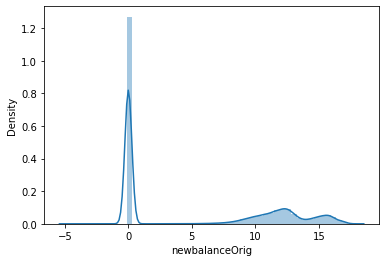

In [31]:
# As we observe that the newbalanceOrig column is highly skewed, we will perform log transformation on the newbalanceOrig column
data['newbalanceOrig'] = np.log(data['newbalanceOrig'], where=data['newbalanceOrig']!=0)
# plot the distribution of the newbalanceOrig column
sns.distplot(data['newbalanceOrig'])

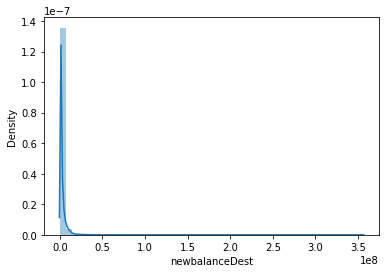

In [32]:
# plot the distribution of the newbalanceDest column    
sns.distplot(data['newbalanceDest'])

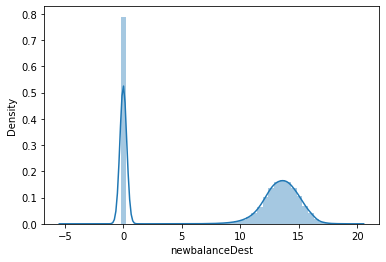

In [33]:
# As we observe that the newbalanceDest column is highly skewed, we will perform log transformation on the newbalanceDest column
data['newbalanceDest'] = np.log(data['newbalanceDest'], where=data['newbalanceDest']!=0)
# plot the distribution of the newbalanceDest column
sns.distplot(data['newbalanceDest'])

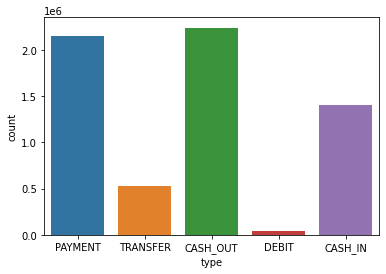

In [34]:
# plot the distribution of the type column
sns.countplot(data['type'])

- We observe that most payments are either PAYMENT or CASH_OUT Type and the DEBIT is the least type used

In [35]:
# Evaluate descriptive statistics for all the columns
data.describe()

,amount,newbalanceOrig,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.084064e+01,5.366048e+00,8.330596e+00,1.290820e-03
std,1.815323e+00,6.330029e+00,6.675098e+00,3.590480e-02
min,-4.605170e+00,-4.605170e+00,-4.605170e+00,0.000000e+00
25%,9.502231e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.122353e+01,0.000000e+00,1.227682e+01,0.000000e+00
75%,1.224876e+01,1.187936e+01,1.392159e+01,0.000000e+00
max,1.834213e+01,1.771920e+01,1.969094e+01,1.000000e+00


In [36]:
# explore bivariate relationships between the features and the target column
# sns.pairplot(data, hue='isFraud')

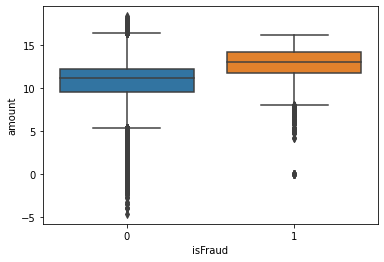

In [37]:
# explore bivariate relationships between the amount feature and the target column
sns.boxplot(x='isFraud', y='amount', data=data)


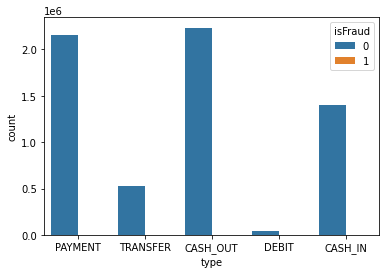

In [38]:
# explore bivariate relationships between the type feature and the target column
sns.countplot(x='type', hue='isFraud', data=data)

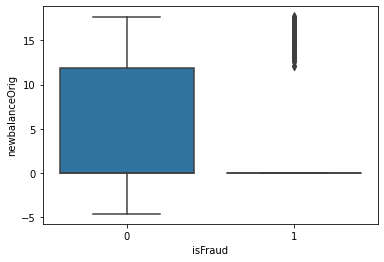

In [39]:
# explore bivariate relationships between the newbalanceOrig feature and the target column
sns.boxplot(x='isFraud', y='newbalanceOrig', data=data)

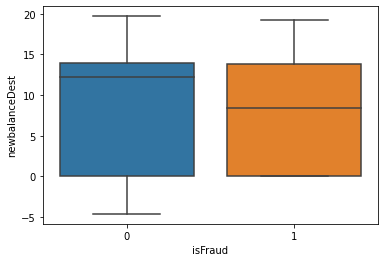

In [40]:
# explore bivariate relationships between the newbalanceDest feature and the target column
sns.boxplot(x='isFraud', y='newbalanceDest', data=data)

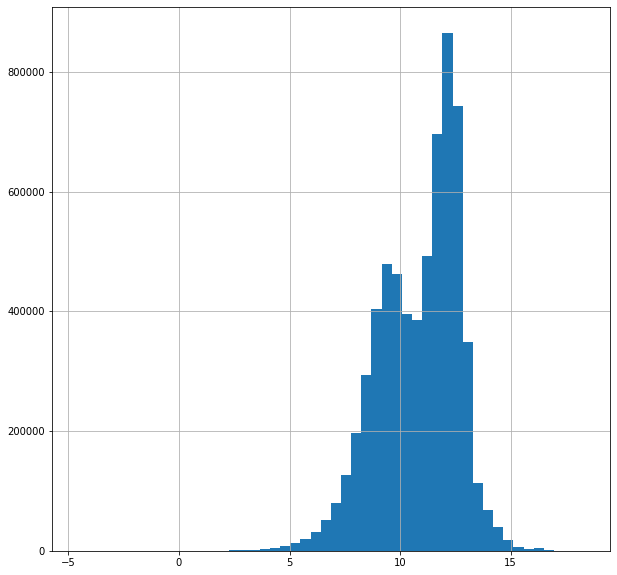

In [41]:
# plot the histogram of the amount column
data['amount'].hist(bins=50, figsize=(10,10))


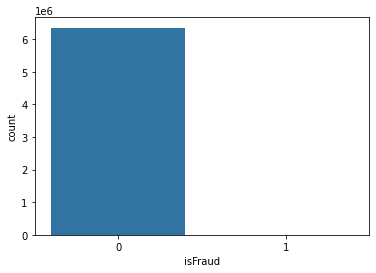

In [42]:
# plot a barplot of target column
sns.countplot(data['isFraud'])

In [43]:
# encode the type column using one hot encoding
data = pd.get_dummies(data, columns=['type'], drop_first=True)
data.head()

,amount,newbalanceOrig,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9.194174,11.984780,0.0,0,0,0,1,0
1,7.530630,9.872240,0.0,0,0,0,1,0
2,5.198497,0.000000,0.0,1,0,0,0,1
3,5.198497,0.000000,0.0,1,1,0,0,0
4,9.364617,10.305141,0.0,0,0,0,1,0


In [44]:
# normalize the amount,newbalanceOrig,newbalanceDest columns using standard scaler
# import the StandardScaler class
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# fit the scaler on the amount column
data['amount'] = scaler.fit_transform(data['amount'].values.reshape(-1,1))
# fit the scaler on the newbalanceOrig column
data['newbalanceOrig'] = scaler.fit_transform(data['newbalanceOrig'].values.reshape(-1,1))
# fit the scaler on the newbalanceDest column
data['newbalanceDest'] = scaler.fit_transform(data['newbalanceDest'].values.reshape(-1,1))
data.head()


,amount,newbalanceOrig,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.906982,1.045609,-1.248011,0,0,0,1,0
1,-1.823372,0.711876,-1.248011,0,0,0,1,0
2,-3.108065,-0.847713,-1.248011,1,0,0,0,1
3,-3.108065,-0.847713,-1.248011,1,1,0,0,0
4,-0.813091,0.780264,-1.248011,0,0,0,1,0


In [45]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [46]:
# train all these models on the train set and evaluate their performance on the test set

    # "LR": LogisticRegression()
    # "KNN": KNeighborsClassifier()
    # "DT": DecisionTreeClassifier()
    # "RF": RandomForestClassifier()
    # "XGB": XGBClassifier()
    # "Naive Bayes": GaussianNB()
    # "SVC": SVC()

# import the required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# create a dictionary of all the models
models_base = {
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
    # "SVC": SVC()
}
models_high= {
    "DT": DecisionTreeClassifier(max_depth=3),
    "RF": RandomForestClassifier(max_depth=3),
    "XGB": XGBClassifier(max_depth=3)
}


In [47]:

# create a function to train and test the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    """
    # set random seed
    np.random.seed(42)
    # make a dictionary to keep model scores
    model_scores = {}
    # loop through models
    for name, model in models.items():
        # fit the model to the data
        model.fit(X_train, y_train)
        # evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        print(name, "Done!")
        print("Accuracy Score: ", accuracy_score(y_test, y_pred))
        print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))
        print("Classification Report: ", classification_report(y_test, y_pred))
        # plot confusion matrix
        # sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
        print("------"*10)
    return model_scores



LR Done!
Accuracy Score:  0.9989956967412795
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.89      0.24      0.38      2435

    accuracy                           1.00   1908786
   macro avg       0.94      0.62      0.69   1908786
weighted avg       1.00      1.00      1.00   1908786

------------------------------------------------------------
KNN Done!
Accuracy Score:  0.9993629458724027
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.84      0.62      0.71      2435

    accuracy                           1.00   1908786
   macro avg       0.92      0.81      0.86   1908786
weighted avg       1.00      1.00      1.00   1908786

------------------------------------------------------------
Naive Bayes Done!
Accuracy Score:  0.592920840785714
Classification Report:          

{'LR': 0.9989956967412795,
 'KNN': 0.9993629458724027,
 'Naive Bayes': 0.592920840785714}

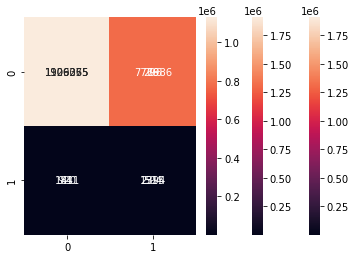

In [48]:
# evaluate the base models
model_scores_base = fit_and_score(models=models_base,
                                X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_scores_base

DT Done!
Accuracy Score:  0.9990046029256292
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.85      0.27      0.40      2435

    accuracy                           1.00   1908786
   macro avg       0.93      0.63      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786

------------------------------------------------------------
RF Done!
Accuracy Score:  0.9987463235794898
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       1.00      0.02      0.03      2435

    accuracy                           1.00   1908786
   macro avg       1.00      0.51      0.52   1908786
weighted avg       1.00      1.00      1.00   1908786

------------------------------------------------------------
[06:15:42] WARNING: /workspace/src/learner.cc:686: Tree method is automatically select

{'DT': 0.9990046029256292, 'RF': 0.9987463235794898, 'XGB': 0.9993577069404322}

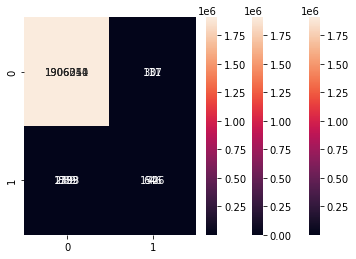

In [49]:
# evaluate the high models
model_scores_high = fit_and_score(models=models_high,
                                X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_scores_high

### Handling imbalanced data

In [52]:
# Use Smote to balance the dataset
# import the SMOTE class
from imblearn.over_sampling import SMOTE
# instantiate the SMOTE class
smote = SMOTE()
# fit the smote on the train set
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote.shape

(8896112, 7)

LR Done!
Accuracy Score:  0.8109547115286889
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.81      0.90   1906351
           1       0.01      0.91      0.01      2435

    accuracy                           0.81   1908786
   macro avg       0.50      0.86      0.45   1908786
weighted avg       1.00      0.81      0.89   1908786

------------------------------------------------------------
KNN Done!
Accuracy Score:  0.9473120611739608
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906351
           1       0.02      0.77      0.04      2435

    accuracy                           0.95   1908786
   macro avg       0.51      0.86      0.50   1908786
weighted avg       1.00      0.95      0.97   1908786

------------------------------------------------------------
Naive Bayes Done!
Accuracy Score:  0.4772588441030058
Classification Report:         

{'LR': 0.8109547115286889,
 'KNN': 0.9473120611739608,
 'Naive Bayes': 0.4772588441030058}

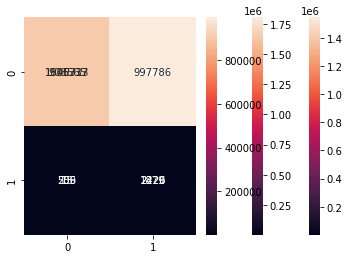

In [53]:
# evaluate the  base models
model_scores_base_smt = fit_and_score(models=models_base,
                                X_train=X_train_smote, X_test=X_test, y_train=y_train_smote, y_test=y_test)

model_scores_base_smt

DT Done!
Accuracy Score:  0.607282324996097
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.61      0.76   1906351
           1       0.00      1.00      0.01      2435

    accuracy                           0.61   1908786
   macro avg       0.50      0.80      0.38   1908786
weighted avg       1.00      0.61      0.75   1908786

------------------------------------------------------------
RF Done!
Accuracy Score:  0.7769514235749843
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.78      0.87   1906351
           1       0.01      0.91      0.01      2435

    accuracy                           0.78   1908786
   macro avg       0.50      0.84      0.44   1908786
weighted avg       1.00      0.78      0.87   1908786

------------------------------------------------------------
[08:13:33] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selecte

{'DT': 0.607282324996097, 'RF': 0.7769514235749843, 'XGB': 0.9294970730087082}

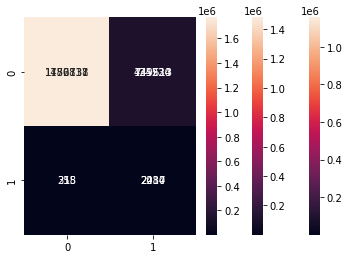

In [54]:
# evaluate the  base models
model_scores_high_smt = fit_and_score(models=models_high,
                                X_train=X_train_smote, X_test=X_test, y_train=y_train_smote, y_test=y_test)

model_scores_high_smt